In [ ]:
# Install packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set display options for better visibility
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Matplotlib style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
# Load the dataset
df = pd.read_csv('hotel_bookings.csv')

print("="*80)
print("DATASET LOADED SUCCESSFULLY")
print("="*80)
print(f"\nDataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\n" + "="*80)
print("FIRST 5 ROWS")
print("="*80)
print(df.head())
print("\n" + "="*80)
print("LAST 5 ROWS (Check for data consistency)")
print("="*80)
print(df.tail())
print("\n" + "="*80)
print("COLUMN DATA TYPES")
print("="*80)
print(df.dtypes)
print("\n" + "="*80)
print("BASIC STATISTICS")
print("="*80)
print(df.describe())

DATASET LOADED SUCCESSFULLY

Dataset Shape: 119,390 rows × 32 columns
Memory Usage: 93.78 MB

FIRST 5 ROWS
          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults 

MISSING VALUES ANALYSIS
  Column  Missing_Count  Missing_Percentage  NULL_String_Count Data_Type
 company         112593               94.31                  0   float64
   agent          16340               13.69                  0   float64
 country            488                0.41                  0    object
children              4                0.00                  0   float64


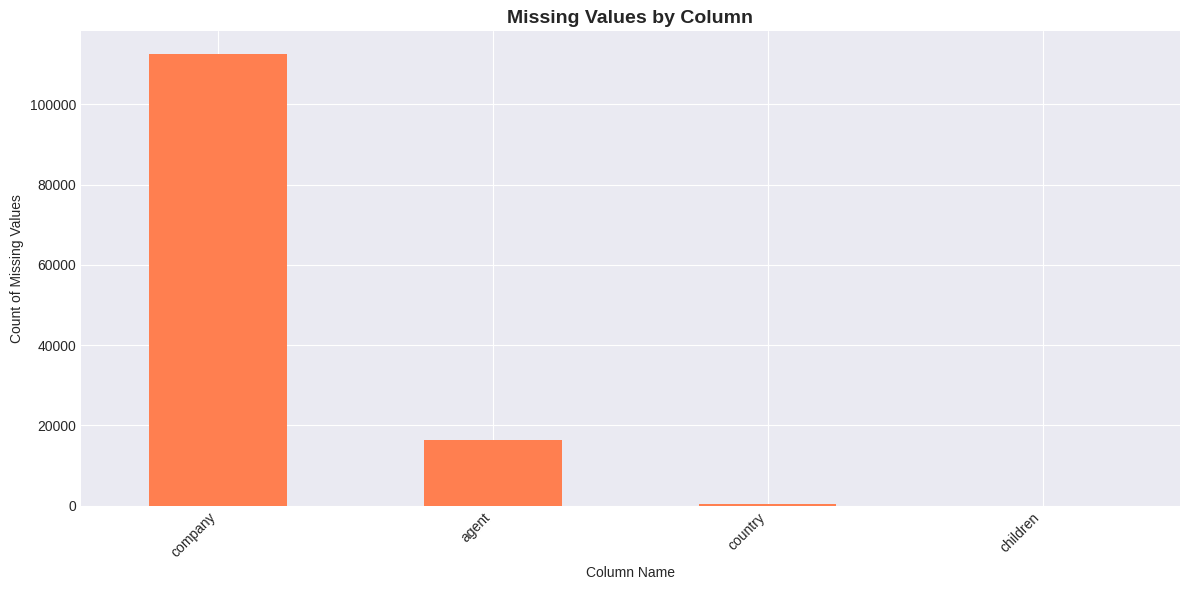

In [ ]:
print("="*80)
print("MISSING VALUES ANALYSIS")
print("="*80)

# Count missing values (including "NULL" strings)
missing_analysis = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2),
    'NULL_String_Count': (df == 'NULL').sum(),  # Check for "NULL" strings
    'Data_Type': df.dtypes
})

missing_analysis = missing_analysis.sort_values('Missing_Percentage', ascending=False)
missing_analysis = missing_analysis[missing_analysis['Missing_Count'] > 0]

print(missing_analysis.to_string(index=False))

# Visualize missing data
plt.figure(figsize=(12, 6))
missing_data = df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)
if len(missing_data) > 0:
    missing_data.plot(kind='bar', color='coral')
    plt.title('Missing Values by Column', fontsize=14, fontweight='bold')
    plt.ylabel('Count of Missing Values')
    plt.xlabel('Column Name')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("\n✓ No traditional missing values found (but check for 'NULL' strings)")

In [ ]:
print("\n" + "="*80)
print("DATA QUALITY ISSUES DETECTION")
print("="*80)

# 1. Negative ADR values (CRITICAL ISSUE)
negative_adr = df[df['adr'] < 0]
print(f"\n1. NEGATIVE ADR VALUES: {len(negative_adr)} records found")
if len(negative_adr) > 0:
    print(negative_adr[['hotel', 'adr', 'country', 'market_segment', 'is_canceled', 'reservation_status']].head(10))

# 2. Zero ADR values (need investigation)
zero_adr = df[df['adr'] == 0]
print(f"\n2. ZERO ADR VALUES: {len(zero_adr)} records ({len(zero_adr)/len(df)*100:.2f}%)")
print("Sample records:")
print(zero_adr[['hotel', 'adr', 'is_canceled', 'reservation_status', 'market_segment']].head(10))

# 3. Zero total guests (adults=0, children=0, babies=0)
zero_guests = df[(df['adults'] == 0) & (df['children'] == 0) & (df['babies'] == 0)]
print(f"\n3. ZERO TOTAL GUESTS: {len(zero_guests)} records (INVALID DATA)")
if len(zero_guests) > 0:
    print(zero_guests[['hotel', 'adults', 'children', 'babies', 'adr', 'reservation_status']].head())

# 4. Country NULL values
country_null = df[df['country'] == 'NULL']
print(f"\n4. COUNTRY = 'NULL': {len(country_null)} records ({len(country_null)/len(df)*100:.2f}%)")

# 5. Duplicate records
duplicates = df.duplicated(keep=False)
print(f"\n5. DUPLICATE RECORDS: {duplicates.sum()} records ({duplicates.sum()/len(df)*100:.2f}%)")

# 6. Undefined meal type
undefined_meal = df[df['meal'] == 'Undefined']
print(f"\n6. MEAL = 'Undefined': {len(undefined_meal)} records")

# 7. Check for adults=0 with children>0 (illogical)
no_adult_with_kids = df[(df['adults'] == 0) & ((df['children'] > 0) | (df['babies'] > 0))]
print(f"\n7. NO ADULTS BUT CHILDREN/BABIES: {len(no_adult_with_kids)} records (ILLOGICAL)")

# Summary of issues
print("\n" + "="*80)
print("SUMMARY: RECORDS REQUIRING ATTENTION")
print("="*80)
issues_summary = pd.DataFrame({
    'Issue': ['Negative ADR', 'Zero ADR', 'Zero Guests', 'NULL Country',
              'Duplicates', 'Undefined Meal', 'No Adults with Kids'],
    'Count': [len(negative_adr), len(zero_adr), len(zero_guests),
              len(country_null), duplicates.sum(), len(undefined_meal),
              len(no_adult_with_kids)],
    'Percentage': [
        len(negative_adr)/len(df)*100,
        len(zero_adr)/len(df)*100,
        len(zero_guests)/len(df)*100,
        len(country_null)/len(df)*100,
        duplicates.sum()/len(df)*100,
        len(undefined_meal)/len(df)*100,
        len(no_adult_with_kids)/len(df)*100
    ]
})
print(issues_summary.to_string(index=False))


DATA QUALITY ISSUES DETECTION

1. NEGATIVE ADR VALUES: 3 records found
              hotel    adr country market_segment  is_canceled  \
70     Resort Hotel -97.00     PRT      Online TA            1   
136    Resort Hotel -98.00     PRT      Online TA            0   
14969  Resort Hotel  -6.38     GBR         Groups            0   

      reservation_status  
70              Canceled  
136            Check-Out  
14969          Check-Out  

2. ZERO ADR VALUES: 1959 records (1.64%)
Sample records:
            hotel  adr  is_canceled reservation_status market_segment
0    Resort Hotel 0.00            0          Check-Out         Direct
1    Resort Hotel 0.00            0          Check-Out         Direct
125  Resort Hotel 0.00            0          Check-Out  Complementary
167  Resort Hotel 0.00            0          Check-Out      Online TA
168  Resort Hotel 0.00            0          Check-Out         Direct
196  Resort Hotel 0.00            0          Check-Out         Direct
197  Re

In [ ]:
print("\n" + "="*80)
print("CATEGORICAL COLUMNS ANALYSIS")
print("="*80)

categorical_cols = ['hotel', 'meal', 'country', 'market_segment',
                    'distribution_channel', 'reserved_room_type',
                    'assigned_room_type', 'deposit_type', 'customer_type',
                    'reservation_status']

for col in categorical_cols:
    unique_count = df[col].nunique()
    print(f"\n{col.upper()}: {unique_count} unique values")
    print("-" * 60)
    value_counts = df[col].value_counts().head(10)
    for value, count in value_counts.items():
        pct = count / len(df) * 100
        print(f"  {value:30s}: {count:>7,} ({pct:>5.2f}%)")

    if unique_count > 10:
        print(f"  ... and {unique_count - 10} more values")

# Check country code standardization issues
print("\n" + "="*80)
print("COUNTRY CODE STANDARDIZATION CHECK")
print("="*80)
non_standard_countries = ['CN', 'TMP', 'NULL']
for country in non_standard_countries:
    count = (df['country'] == country).sum()
    if count > 0:
        print(f"  {country}: {count} records (needs standardization)")


CATEGORICAL COLUMNS ANALYSIS

HOTEL: 2 unique values
------------------------------------------------------------
  City Hotel                    :  79,330 (66.45%)
  Resort Hotel                  :  40,060 (33.55%)

MEAL: 5 unique values
------------------------------------------------------------
  BB                            :  92,310 (77.32%)
  HB                            :  14,463 (12.11%)
  SC                            :  10,650 ( 8.92%)
  Undefined                     :   1,169 ( 0.98%)
  FB                            :     798 ( 0.67%)

COUNTRY: 177 unique values
------------------------------------------------------------
  PRT                           :  48,590 (40.70%)
  GBR                           :  12,129 (10.16%)
  FRA                           :  10,415 ( 8.72%)
  ESP                           :   8,568 ( 7.18%)
  DEU                           :   7,287 ( 6.10%)
  ITA                           :   3,766 ( 3.15%)
  IRL                           :   3,375 ( 2.83%


NUMERIC COLUMNS DISTRIBUTION

LEAD_TIME
------------------------------------------------------------
  Min: 0.00
  Max: 737.00
  Mean: 104.01
  Median: 69.00
  Std Dev: 106.86
  ⚠️  Extreme outliers: 181 records

STAYS_IN_WEEKEND_NIGHTS
------------------------------------------------------------
  Min: 0.00
  Max: 19.00
  Mean: 0.93
  Median: 1.00
  Std Dev: 1.00
  ⚠️  Extreme outliers: 33 records

STAYS_IN_WEEK_NIGHTS
------------------------------------------------------------
  Min: 0.00
  Max: 50.00
  Mean: 2.50
  Median: 2.00
  Std Dev: 1.91
  ⚠️  Extreme outliers: 1438 records

ADULTS
------------------------------------------------------------
  Min: 0.00
  Max: 55.00
  Mean: 1.86
  Median: 2.00
  Std Dev: 0.58
  ⚠️  Extreme outliers: 29710 records

CHILDREN
------------------------------------------------------------
  Min: 0.00
  Max: 10.00
  Mean: 0.10
  Median: 0.00
  Std Dev: 0.40
  ⚠️  Extreme outliers: 8590 records

BABIES
-----------------------------------------------

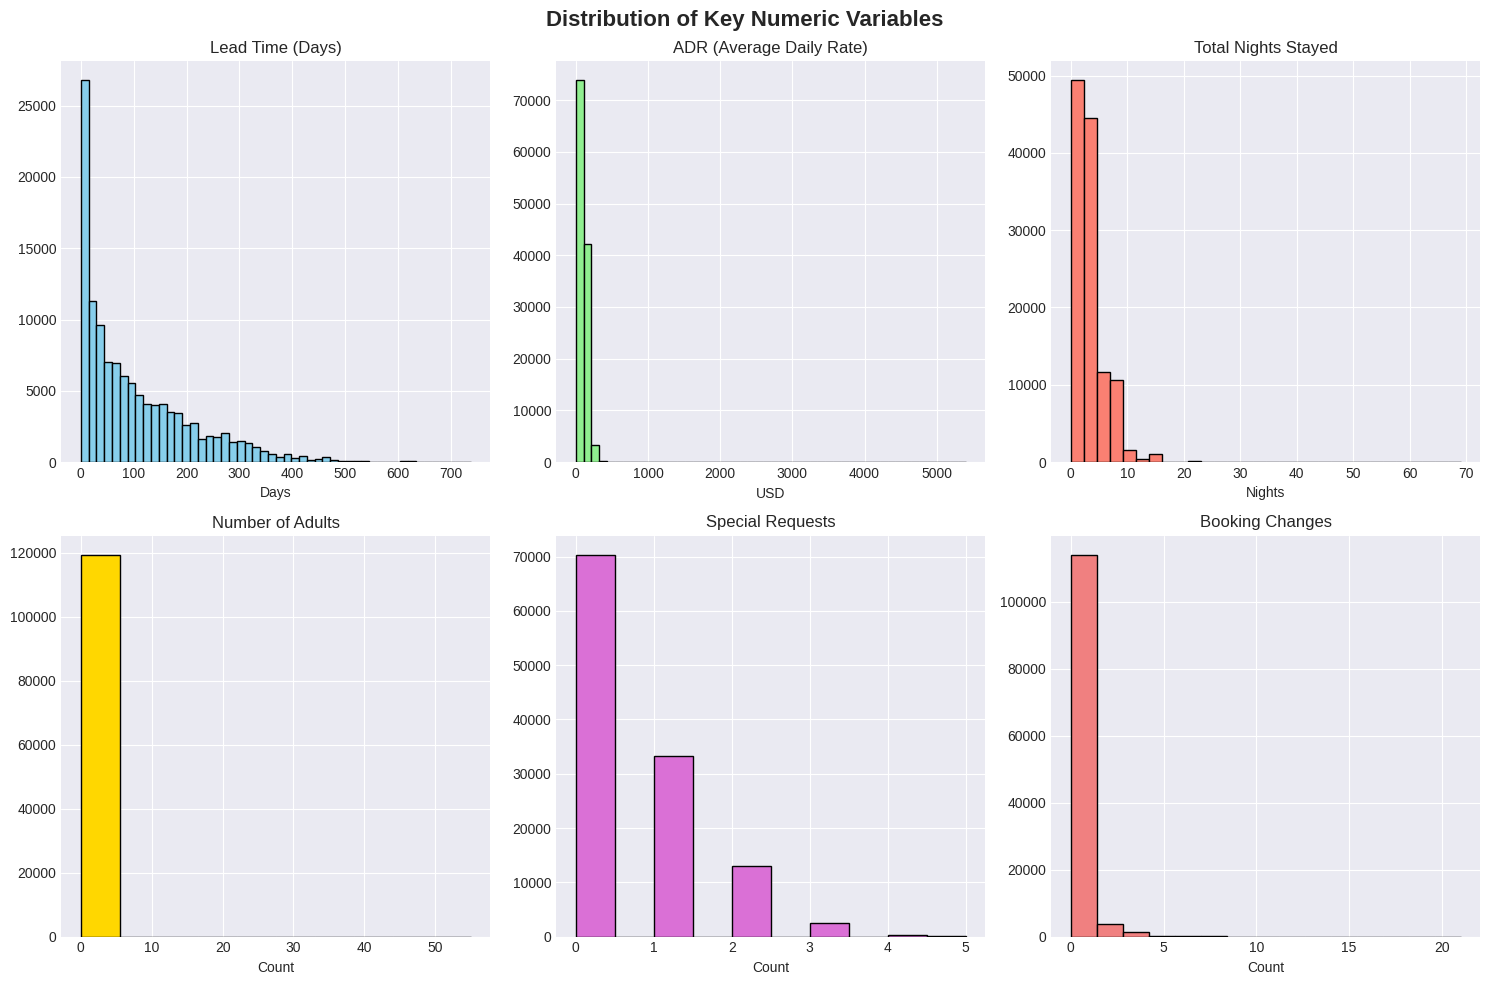

In [ ]:
print("\n" + "="*80)
print("NUMERIC COLUMNS DISTRIBUTION")
print("="*80)

numeric_cols = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights',
                'adults', 'children', 'babies', 'previous_cancellations',
                'previous_bookings_not_canceled', 'booking_changes',
                'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
                'total_of_special_requests']

# Create distribution analysis
for col in numeric_cols:
    print(f"\n{col.upper()}")
    print("-" * 60)
    stats = df[col].describe()
    print(f"  Min: {stats['min']:.2f}")
    print(f"  Max: {stats['max']:.2f}")
    print(f"  Mean: {stats['mean']:.2f}")
    print(f"  Median: {stats['50%']:.2f}")
    print(f"  Std Dev: {stats['std']:.2f}")

    # Check for extreme outliers
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    outliers = df[(df[col] < q1 - 3*iqr) | (df[col] > q3 + 3*iqr)]
    if len(outliers) > 0:
        print(f"  ⚠️  Extreme outliers: {len(outliers)} records")

# Visualize key distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribution of Key Numeric Variables', fontsize=16, fontweight='bold')

# Lead time
axes[0, 0].hist(df['lead_time'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Lead Time (Days)')
axes[0, 0].set_xlabel('Days')

# ADR (excluding negatives for visualization)
axes[0, 1].hist(df[df['adr'] >= 0]['adr'], bins=50, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('ADR (Average Daily Rate)')
axes[0, 1].set_xlabel('USD')

# Total stays
df['total_nights'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']
axes[0, 2].hist(df['total_nights'], bins=30, color='salmon', edgecolor='black')
axes[0, 2].set_title('Total Nights Stayed')
axes[0, 2].set_xlabel('Nights')

# Adults
axes[1, 0].hist(df['adults'], bins=10, color='gold', edgecolor='black')
axes[1, 0].set_title('Number of Adults')
axes[1, 0].set_xlabel('Count')

# Special requests
axes[1, 1].hist(df['total_of_special_requests'], bins=10, color='orchid', edgecolor='black')
axes[1, 1].set_title('Special Requests')
axes[1, 1].set_xlabel('Count')

# Booking changes
axes[1, 2].hist(df['booking_changes'], bins=15, color='lightcoral', edgecolor='black')
axes[1, 2].set_title('Booking Changes')
axes[1, 2].set_xlabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
print("="*80)
print("DATA CLEANING PROCESS STARTED")
print("="*80)

# Create a copy for cleaning (preserve original)
df_clean = df.copy()
print(f"\nOriginal dataset: {len(df_clean):,} records")

# ============================================================================
# 1. FIX NEGATIVE ADR VALUES
# ============================================================================
print("\n" + "-"*80)
print("1. FIXING NEGATIVE ADR VALUES")
print("-"*80)

negative_adr_count = (df_clean['adr'] < 0).sum()
print(f"Records with negative ADR: {negative_adr_count}")

# Strategy: Convert to absolute value (likely data entry sign error)
df_clean.loc[df_clean['adr'] < 0, 'adr'] = df_clean.loc[df_clean['adr'] < 0, 'adr'].abs()
print(f"✓ Converted negative ADR to absolute values")

# Verify fix
remaining_negative = (df_clean['adr'] < 0).sum()
print(f"Remaining negative values: {remaining_negative}")

# ============================================================================
# 2. REMOVE RECORDS WITH ZERO TOTAL GUESTS
# ============================================================================
print("\n" + "-"*80)
print("2. REMOVING INVALID RECORDS (Zero Total Guests)")
print("-"*80)

zero_guests = (df_clean['adults'] == 0) & (df_clean['children'] == 0) & (df_clean['babies'] == 0)
zero_guests_count = zero_guests.sum()
print(f"Records with zero guests: {zero_guests_count}")

df_clean = df_clean[~zero_guests]
print(f"✓ Removed {zero_guests_count} invalid records")
print(f"Dataset after removal: {len(df_clean):,} records")

# ============================================================================
# 3. HANDLE NULL STRINGS IN AGENT, COMPANY, COUNTRY
# ============================================================================
print("\n" + "-"*80)
print("3. HANDLING 'NULL' STRINGS")
print("-"*80)

# Replace 'NULL' string with actual NaN
for col in ['agent', 'company', 'country']:
    null_count = (df_clean[col] == 'NULL').sum()
    print(f"{col}: {null_count} 'NULL' strings found")
    df_clean[col] = df_clean[col].replace('NULL', np.nan)
    print(f"  ✓ Replaced with NaN")

# ============================================================================
# 4. STANDARDIZE COUNTRY CODES
# ============================================================================
print("\n" + "-"*80)
print("4. STANDARDIZING COUNTRY CODES")
print("-"*80)

country_mapping = {
    'CN': 'CHN',  # China
    'TMP': 'TLS'  # East Timor (Timor-Leste)
}

for old_code, new_code in country_mapping.items():
    count = (df_clean['country'] == old_code).sum()
    if count > 0:
        df_clean['country'] = df_clean['country'].replace(old_code, new_code)
        print(f"✓ Replaced {old_code} → {new_code} ({count} records)")

# Handle NULL countries - replace with 'Unknown'
null_country_count = df_clean['country'].isna().sum()
if null_country_count > 0:
    df_clean['country'] = df_clean['country'].fillna('Unknown')
    print(f"✓ Replaced {null_country_count} NULL countries with 'Unknown'")

# ============================================================================
# 5. STANDARDIZE MEAL TYPE
# ============================================================================
print("\n" + "-"*80)
print("5. STANDARDIZING MEAL TYPES")
print("-"*80)

undefined_meal_count = (df_clean['meal'] == 'Undefined').sum()
print(f"'Undefined' meal types: {undefined_meal_count}")

# Replace Undefined with SC (Self Catering - most conservative)
df_clean['meal'] = df_clean['meal'].replace('Undefined', 'SC')
print(f"✓ Replaced 'Undefined' → 'SC' (Self Catering)")

# ============================================================================
# 6. HANDLE DUPLICATES
# ============================================================================
print("\n" + "-"*80)
print("6. HANDLING DUPLICATE RECORDS")
print("-"*80)

duplicates_count = df_clean.duplicated().sum()
print(f"Exact duplicate records: {duplicates_count}")

if duplicates_count > 0:
    # Keep first occurrence
    df_clean = df_clean.drop_duplicates(keep='first')
    print(f"✓ Removed {duplicates_count} duplicate records")
    print(f"Dataset after deduplication: {len(df_clean):,} records")

# ============================================================================
# 7. CREATE DERIVED COLUMNS - TEMPORAL
# ============================================================================
print("\n" + "-"*80)
print("7. CREATING DERIVED TEMPORAL COLUMNS")
print("-"*80)

# Map month names to numbers
month_mapping = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}

df_clean['arrival_date_month_num'] = df_clean['arrival_date_month'].map(month_mapping)

# Create full arrival date
df_clean['arrival_date'] = pd.to_datetime(
    df_clean['arrival_date_year'].astype(str) + '-' +
    df_clean['arrival_date_month_num'].astype(str) + '-' +
    df_clean['arrival_date_day_of_month'].astype(str),
    format='%Y-%m-%d',
    errors='coerce'
)

print(f"✓ Created 'arrival_date' column")

# Create booking date (arrival - lead_time)
df_clean['booking_date'] = df_clean['arrival_date'] - pd.to_timedelta(df_clean['lead_time'], unit='D')
print(f"✓ Created 'booking_date' column")

# Extract temporal features
df_clean['booking_year'] = df_clean['booking_date'].dt.year
df_clean['booking_month'] = df_clean['booking_date'].dt.month
df_clean['booking_quarter'] = df_clean['booking_date'].dt.quarter
df_clean['arrival_quarter'] = df_clean['arrival_date'].dt.quarter
df_clean['day_of_week'] = df_clean['arrival_date'].dt.day_name()
df_clean['is_weekend_arrival'] = df_clean['arrival_date'].dt.dayofweek >= 5

print(f"✓ Created temporal features: year, month, quarter, day_of_week, is_weekend")

# Create season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # 9, 10, 11
        return 'Fall'

df_clean['arrival_season'] = df_clean['arrival_date_month_num'].apply(get_season)
df_clean['booking_season'] = df_clean['booking_month'].apply(lambda x: get_season(x) if pd.notna(x) else np.nan)

print(f"✓ Created 'season' columns")

# ============================================================================
# 8. CREATE DERIVED COLUMNS - FINANCIAL
# ============================================================================
print("\n" + "-"*80)
print("8. CREATING FINANCIAL DERIVED COLUMNS")
print("-"*80)

# Total nights
df_clean['total_nights'] = df_clean['stays_in_weekend_nights'] + df_clean['stays_in_week_nights']
print(f"✓ Created 'total_nights'")

# Total revenue (only for completed stays)
df_clean['total_revenue'] = df_clean['adr'] * df_clean['total_nights']
print(f"✓ Created 'total_revenue'")

# Flag complimentary stays
df_clean['is_complimentary'] = (df_clean['adr'] == 0) & (df_clean['reservation_status'] == 'Check-Out')
complimentary_count = df_clean['is_complimentary'].sum()
print(f"✓ Created 'is_complimentary' flag ({complimentary_count} records)")

# Revenue per guest (avoiding division by zero)
df_clean['total_guests'] = df_clean['adults'] + df_clean['children'] + df_clean['babies']
df_clean['revenue_per_guest'] = np.where(
    df_clean['total_guests'] > 0,
    df_clean['total_revenue'] / df_clean['total_guests'],
    0
)
print(f"✓ Created 'revenue_per_guest'")

# Weekend ratio
df_clean['weekend_ratio'] = np.where(
    df_clean['total_nights'] > 0,
    df_clean['stays_in_weekend_nights'] / df_clean['total_nights'],
    0
)
print(f"✓ Created 'weekend_ratio'")

# ============================================================================
# 9. CREATE DERIVED COLUMNS - CUSTOMER BEHAVIOR
# ============================================================================
print("\n" + "-"*80)
print("9. CREATING CUSTOMER BEHAVIOR COLUMNS")
print("-"*80)

# Family indicators
df_clean['is_family'] = (df_clean['children'] > 0) | (df_clean['babies'] > 0)
df_clean['has_children'] = df_clean['children'] > 0
df_clean['has_babies'] = df_clean['babies'] > 0

print(f"✓ Created family indicators")

# Party size category
def categorize_party_size(row):
    total = row['adults'] + row['children'] + row['babies']
    if total == 1:
        return 'Solo'
    elif total == 2 and row['children'] == 0 and row['babies'] == 0:
        return 'Couple'
    elif row['children'] > 0 or row['babies'] > 0:
        return 'Family'
    else:
        return 'Group'

df_clean['party_type'] = df_clean.apply(categorize_party_size, axis=1)
print(f"✓ Created 'party_type' category")

# Special needs indicator
df_clean['has_special_requests'] = df_clean['total_of_special_requests'] > 0
print(f"✓ Created 'has_special_requests' flag")

# Guest loyalty level
def categorize_loyalty(row):
    if row['is_repeated_guest'] == 1:
        return 'Returning'
    elif row['previous_bookings_not_canceled'] > 0:
        return 'Returning'
    else:
        return 'New'

df_clean['guest_loyalty'] = df_clean.apply(categorize_loyalty, axis=1)
print(f"✓ Created 'guest_loyalty' category")

# ============================================================================
# 10. CREATE DERIVED COLUMNS - BOOKING BEHAVIOR
# ============================================================================
print("\n" + "-"*80)
print("10. CREATING BOOKING BEHAVIOR COLUMNS")
print("-"*80)

# Lead time category
def categorize_lead_time(days):
    if days == 0:
        return 'Same-Day'
    elif days <= 7:
        return 'Short (≤7 days)'
    elif days <= 30:
        return 'Medium (8-30 days)'
    elif days <= 90:
        return 'Long (31-90 days)'
    else:
        return 'Very Long (>90 days)'

df_clean['lead_time_category'] = df_clean['lead_time'].apply(categorize_lead_time)
print(f"✓ Created 'lead_time_category'")

# Room change indicator
df_clean['room_changed'] = df_clean['reserved_room_type'] != df_clean['assigned_room_type']
df_clean['room_upgraded'] = df_clean['assigned_room_type'] > df_clean['reserved_room_type']
print(f"✓ Created room change indicators")

# Booking complexity
df_clean['has_changes'] = df_clean['booking_changes'] > 0
df_clean['has_deposit'] = df_clean['deposit_type'] != 'No Deposit'
df_clean['has_agent'] = df_clean['agent'].notna()
df_clean['has_company'] = df_clean['company'].notna()

print(f"✓ Created booking complexity flags")

# ============================================================================
# CLEANING SUMMARY
# ============================================================================
print("\n" + "="*80)
print("DATA CLEANING COMPLETED")
print("="*80)
print(f"\nOriginal records: {len(df):,}")
print(f"Cleaned records: {len(df_clean):,}")
print(f"Records removed: {len(df) - len(df_clean):,}")
print(f"Removal rate: {(len(df) - len(df_clean)) / len(df) * 100:.2f}%")

print(f"\nNew derived columns added: {len(df_clean.columns) - len(df.columns)}")
print(f"Total columns now: {len(df_clean.columns)}")

print("\n✓ Dataset is ready for analysis and Power BI export!")

DATA CLEANING PROCESS STARTED

Original dataset: 119,390 records

--------------------------------------------------------------------------------
1. FIXING NEGATIVE ADR VALUES
--------------------------------------------------------------------------------
Records with negative ADR: 3
✓ Converted negative ADR to absolute values
Remaining negative values: 0

--------------------------------------------------------------------------------
2. REMOVING INVALID RECORDS (Zero Total Guests)
--------------------------------------------------------------------------------
Records with zero guests: 180
✓ Removed 180 invalid records
Dataset after removal: 119,210 records

--------------------------------------------------------------------------------
3. HANDLING 'NULL' STRINGS
--------------------------------------------------------------------------------
agent: 0 'NULL' strings found
  ✓ Replaced with NaN
company: 0 'NULL' strings found
  ✓ Replaced with NaN
country: 0 'NULL' strings found
  

In [ ]:
print("="*80)
print("EXPORTING CLEANED DATA FOR POWER BI")
print("="*80)

# Save cleaned dataset
output_file = 'hotel_bookings_cleaned.csv'
df_clean.to_csv(output_file, index=False)
print(f"\n✓ Cleaned data exported to: {output_file}")
print(f"  Records: {len(df_clean):,}")
print(f"  Columns: {len(df_clean.columns)}")

# Show final column list
print("\n" + "-"*80)
print("FINAL COLUMN LIST (for Power BI import)")
print("-"*80)
for i, col in enumerate(df_clean.columns, 1):
    print(f"{i:2d}. {col}")

print("\n✓ Ready for Power BI import!")

EXPORTING CLEANED DATA FOR POWER BI

✓ Cleaned data exported to: hotel_bookings_cleaned.csv
  Records: 87,230
  Columns: 62

--------------------------------------------------------------------------------
FINAL COLUMN LIST (for Power BI import)
--------------------------------------------------------------------------------
 1. hotel
 2. is_canceled
 3. lead_time
 4. arrival_date_year
 5. arrival_date_month
 6. arrival_date_week_number
 7. arrival_date_day_of_month
 8. stays_in_weekend_nights
 9. stays_in_week_nights
10. adults
11. children
12. babies
13. meal
14. country
15. market_segment
16. distribution_channel
17. is_repeated_guest
18. previous_cancellations
19. previous_bookings_not_canceled
20. reserved_room_type
21. assigned_room_type
22. booking_changes
23. deposit_type
24. agent
25. company
26. days_in_waiting_list
27. customer_type
28. adr
29. required_car_parking_spaces
30. total_of_special_requests
31. reservation_status
32. reservation_status_date
33. total_nights
34. ar